In [1]:
from sklearn import svm
import GPyOpt, numpy as np

In [2]:
%run collect_and_name_data.py rnaseq

loading rnaseq data
rnaseq_all_genes: (11216, 104)
rnaseq_effector_genes: (1044, 104)
rnaseq_mod_activities: (89, 104)
rnaseq_mod_genevals: (172, 104)
rnaseq_mod_nodevals: (462, 104)
rnaseq_signaling_genes: (2184, 104)
rnaseq_design: (104, 4)


In [3]:
from paramz import Model, Param

In [15]:
class ParamzSVC(Model):
    def __init__(self, X, y, C=1., gamma=1., name='ParamzSVC'):
        from sklearn.cross_validation import StratifiedKFold
        super(ParamzSVC, self).__init__(name=name)

        self.X = X
        self.y = y
        
        self.C = Param('C', C)
        self.gamma = Param('gamma', gamma)
        self.link_parameter(self.C)
        self.link_parameter(self.gamma)
        self.sk = StratifiedKFold(train_labels, shuffle=True)
        
    def parameters_changed(self):
        from sklearn.metrics import f1_score
    
        self._obj = 0.
        #svc = svm.LinearSVC(C=float(self.C.values), class_weight='balanced')
        svc = svm.SVC(C=float(self.C.values), 
                      gamma=float(self.gamma.values), 
                      kernel='rbf', 
                      decision_function_shape='ovr', 
                      probability=False, 
                      class_weight='balanced')
    
        for train_index, test_index in self.sk:
            svc = svc.fit(self.X[train_index], self.y[train_index])
            prediction = svc.predict(self.X[test_index])
            self._obj += f1_score(self.y[test_index], prediction)/float(self.sk.n_folds)
            
    def objective_function(self):
        import numpy as np
        print self._obj,
        return -np.atleast_1d(self._obj)

In [16]:
train_idx = design.Set == design.Set.unique()[0]
test_idx = ~train_idx    

train_labels = design.loc[train_idx, 'Effect']
test_labels = design.loc[test_idx, 'Effect']

In [17]:
def get_train_test_set(data, train_idx, test_idx):
    train_set = data.loc[:, train_idx].copy()
    from sklearn.preprocessing import StandardScaler
    normalizer = StandardScaler()
    train_set[:] = normalizer.fit_transform(train_set.T).T

    test_set = data.loc[:, test_idx].copy()
    test_set[:] = normalizer.transform(test_set.T).T
    
    return train_set, test_set

In [18]:
def make_f(m):
    def f(X):
        ret = np.empty((X.shape[0],1))
        for i in range(X.shape[0]):
            ret[i] = m._objective(X[i])
        return ret
    return f

In [ ]:
train_errors = {}

for i in range(len(all_data)):
    data = all_data[i]
    print data.name
    train_set, test_set = get_train_test_set(data, train_idx, test_idx)
    
    m = ParamzSVC(train_set.T.values, train_labels.values)
    m_opt = GPyOpt.methods.BayesianOptimization(make_f(m), 
                                            bounds=[
                                                    (1e-100,.3),
                                                    (0,1)
                                                    ], 
                                            model_optimize_restarts = 40,
                                            normalize=True,
                                            acquisition = 'EI',
                                            type_initial_design='latin')
    print
    m_opt.run_optimization(200, eps=1e-5)
    print
    train_errors[data.name] = [m_opt.fx_opt, m_opt.x_opt]

all_genes
0.0699633699634 0.0699633699634 0.0699633699634 0.0699633699634 0.13080993081 0.0699633699634
0.0699633699634 0.0699633699634 0.13080993081 0.0699633699634 0.0699633699634 0.0699633699634 0.13080993081 0.0699633699634 

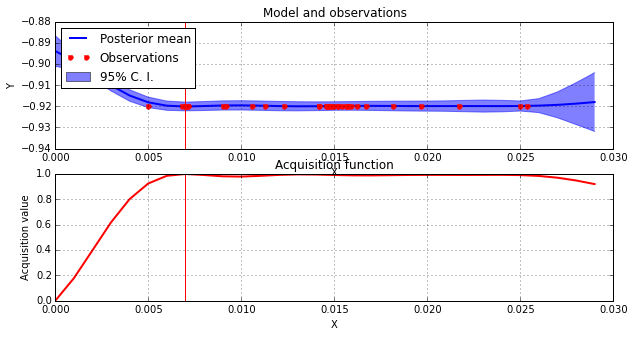

In [237]:
m_opt.plot_acquisition()

In [253]:
train_errors.values()

[[array([-0.82142857]), array([ 0.025])],
 [array([-0.85555556]), array([ 0.01746708])],
 [array([-0.87301587]), array([ 0.025])],
 [array([-0.9047619]), array([ 0.015])],
 [array([-0.91984127]), array([ 0.025])],
 [array([-0.93492063]), array([ 0.015])]]

In [256]:
results = pd.DataFrame(train_errors.values(), 
                       columns=['-acc', 'C', 'gamma'], 
                       index=train_errors.keys(),
                       dtype=float)

In [257]:
results

,-acc,C
mod_activities,-0.821429,0.025000
mod_genevalues,-0.855556,0.017467
mod_nodevalues,-0.873016,0.025000
effector_genes,-0.904762,0.015000
signaling_genes,-0.919841,0.025000
all_genes,-0.934921,0.015000


## Work on all data with linear kernel:

In [258]:
svc = svm.SVC(C=results.loc['all_genes','C'], kernel='linear', decision_function_shape='ovr', probability=True, class_weight='balanced')

In [262]:
train_set, test_set = get_train_test_set(rnaseq_all_genes, train_idx, test_idx)
svc.fit(train_set.T.values, train_labels)

SVC(C=0.014999999999999999, cache_size=200, class_weight='balanced',
  coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [264]:
prediction_labels = svc.predict(test_set.T.values)

In [269]:
prediction_probabilities = pd.DataFrame(svc.predict_proba(test_set.T.values), index=test_set.columns, columns=svc.classes_)

In [271]:
import seaborn as sns

In [300]:
sort = np.argsort(prediction_probabilities).values[:, ::-1]

In [446]:
test_labels.value_counts()
test_labels_collected = test_labels.copy()
test_labels_collected[(test_labels_collected=='Effect_6')+(test_labels_collected=='Effect_7')] = 'Unknown'
#test_labels_collected = pd.get_dummies(test_labels_collected)

In [440]:
for _t in np.setdiff1d(prediction_probabilities.columns, test_labels_collected.columns):
    test_labels_collected[_t] = 0

In [443]:
classification_report(test_labels_collected, prediction)

,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5
RNAseq22,0.511994,0.018103,0.039995,0.158557,0.037280,0.234071
RNAseq23,0.062408,0.051182,0.516748,0.148369,0.080255,0.141038
RNAseq24,0.018346,0.113360,0.250784,0.023249,0.575354,0.018907
RNAseq25,0.008332,0.066352,0.041171,0.012338,0.862535,0.009272
RNAseq26,0.100400,0.068198,0.348709,0.071529,0.300874,0.110289


In [444]:
test_labels_collected.head()

,Control,Effect_1,Effect_2,Unknown,Effect_3,Effect_4,Effect_5
SampleID_RNASeq,,,,,,,
RNAseq22,1.0,0.0,0.0,0.0,0,0,0
RNAseq23,0.0,0.0,1.0,0.0,0,0,0
RNAseq24,0.0,0.0,1.0,0.0,0,0,0
RNAseq25,0.0,0.0,1.0,0.0,0,0,0
RNAseq26,0.0,0.0,0.0,1.0,0,0,0


## Roc curve for each class:

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [316]:
rocs = {}
for c in prediction_probabilities.columns:
    rocs[c] = roc_curve(test_labels_collected==c, prediction_probabilities[c])

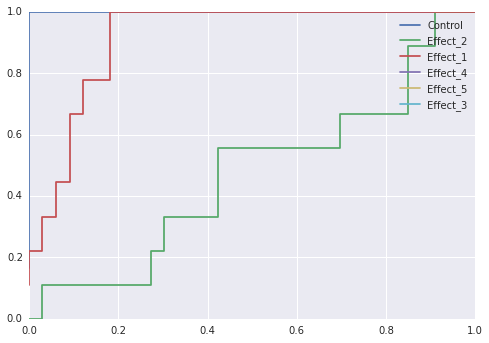

In [322]:
for name in rocs:
    plt.plot(rocs[name][0], rocs[name][1], label=name)
plt.legend()

## Try to use the predicted probabilities to find unknown classes:

In [486]:
def predict_classes(prediction_probabilities, threshold):
    import scipy
    #sort = np.argsort(prediction_probabilities, 1).values[:, ::-1]
    prediction = prediction_probabilities.idxmax(1)
    score = prediction_probabilities.std(1)
    prediction[score<threshold] = 'Unknown'
    return prediction

In [489]:
thresholds = np.linspace(0,1,1000)
accs = pd.DataFrame(columns=['acc', 'prec', 'recall'])
for t in thresholds:
    prediction = predict_classes(prediction_probabilities, t)
    accs.loc[t] = [accuracy_score(test_labels_collected, prediction), precision_score(test_labels_collected, prediction), recall_score(test_labels_collected, prediction)]

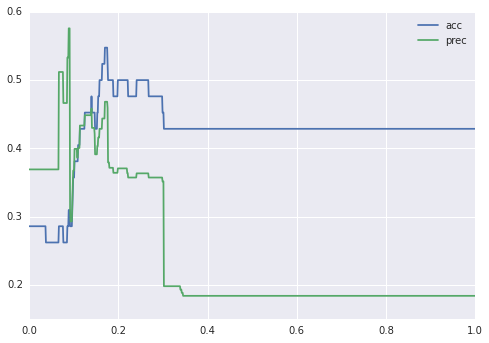

In [490]:
accs.plot()

In [376]:
prediction_probabilities.head()

,Control,Effect_1,Effect_2,Effect_3,Effect_4,Effect_5
RNAseq22,0.511994,0.018103,0.039995,0.158557,0.037280,0.234071
RNAseq23,0.062408,0.051182,0.516748,0.148369,0.080255,0.141038
RNAseq24,0.018346,0.113360,0.250784,0.023249,0.575354,0.018907
RNAseq25,0.008332,0.066352,0.041171,0.012338,0.862535,0.009272
RNAseq26,0.100400,0.068198,0.348709,0.071529,0.300874,0.110289


In [80]:
print classification_report(test_labels, prediction)

             precision    recall  f1-score   support

    Control       1.00      0.50      0.67         6
   Effect_1       0.86      0.67      0.75         9
   Effect_2       0.29      0.44      0.35         9
   Effect_3       0.00      0.00      0.00         0
   Effect_4       0.00      0.00      0.00         0
   Effect_6       0.00      0.00      0.00         9
   Effect_7       0.00      0.00      0.00         9

avg / total       0.39      0.31      0.33        42



/Users/maxz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/maxz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1076: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [85]:
pd.value_counts(prediction)

Effect_2    14
Effect_4    12
Effect_1     7
Effect_3     6
Control      3
dtype: int64

In [83]:
print accuracy_score(test_labels, prediction)

0.309523809524
